/tmp/ipython-input-41-4083365942.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, period=PERIOD, interval=INTERVAL)
[*********************100%***********************]  1 of 1 completed


→ Saved raw hourly data to aapl_hourly_raw.csv
Epoch 01  Train MSE=0.002933  Val MSE=0.000091
Epoch 02  Train MSE=0.001064  Val MSE=0.000354
Epoch 03  Train MSE=0.000727  Val MSE=0.000176
Epoch 04  Train MSE=0.000495  Val MSE=0.000164
Epoch 05  Train MSE=0.000389  Val MSE=0.000028
Epoch 06  Train MSE=0.000297  Val MSE=0.000031
Epoch 07  Train MSE=0.000238  Val MSE=0.000039
Epoch 08  Train MSE=0.000225  Val MSE=0.000039
Epoch 09  Train MSE=0.000156  Val MSE=0.000033
Epoch 10  Train MSE=0.000158  Val MSE=0.000030
⏹ Early stopping at epoch 10
Direction Accuracy: 0.432
              precision    recall  f1-score   support

        Down      0.432     1.000     0.604        16
          Up      0.000     0.000     0.000        21

    accuracy                          0.432        37
   macro avg      0.216     0.500     0.302        37
weighted avg      0.187     0.432     0.261        37



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


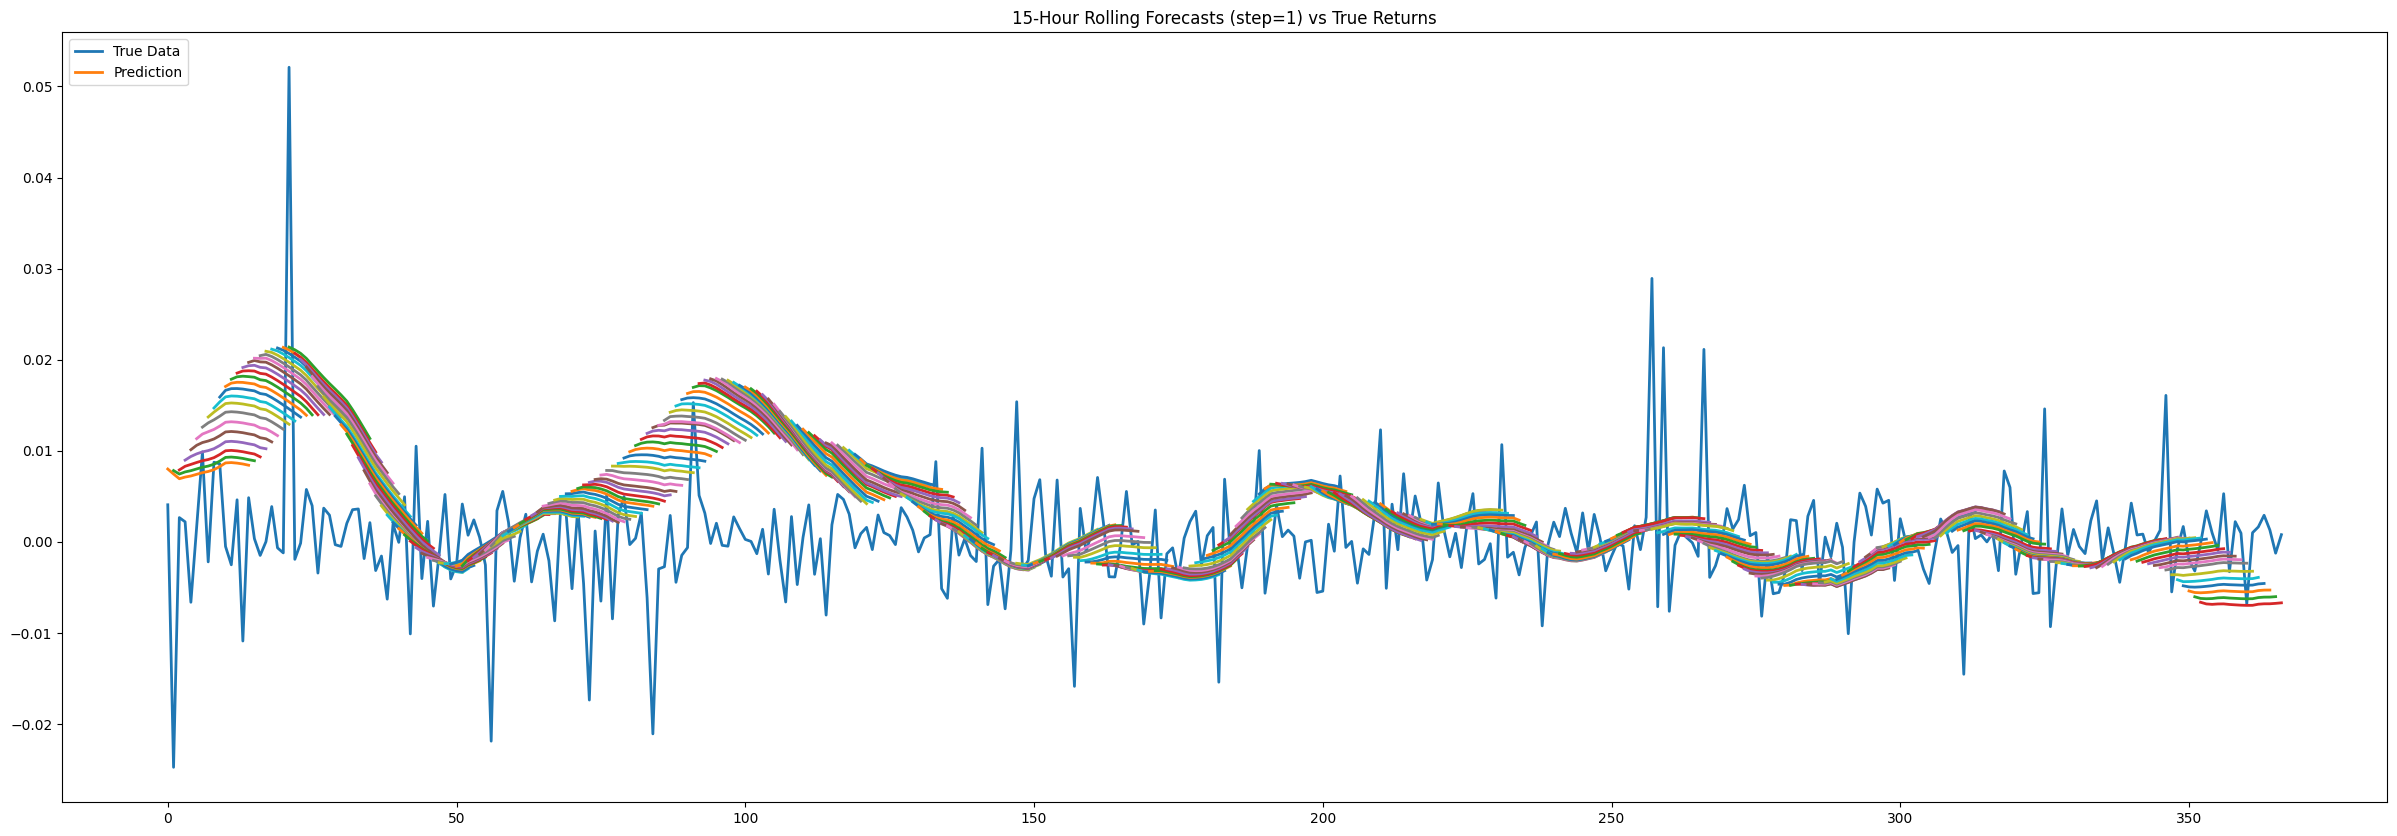

In [41]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing    import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics         import accuracy_score, classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ─── HYPERPARAMS ──────────────────────────────────────────────────────────────
TICKER      = "AAPL"
PERIOD      = "60d"      # intraday limit
INTERVAL    = "1h"
SEQ_LEN     = 30
BATCH       = 64
HORIZON     = 15
STEP        = 1          # slide forecast window every 1 hour
LR          = 1e-3
WEIGHT_DECAY= 1e-5
PATIENCE    = 5
N_EPOCHS    = 50

# ─── 1) DOWNLOAD RAW & SAVE ────────────────────────────────────────────────────
df = yf.download(TICKER, period=PERIOD, interval=INTERVAL)
df.to_csv("aapl_hourly_raw.csv")
print("→ Saved raw hourly data to aapl_hourly_raw.csv")

# ─── 2) FEATURE ENGINEERING ────────────────────────────────────────────────────
for w in (5,10,20):
    df[f"MA_{w}"] = df["Close"].rolling(w).mean()

def compute_rsi(s, window=14):
    d  = s.diff()
    up =  d.clip(lower=0).rolling(window).mean()
    dn = -d.clip(upper=0).rolling(window).mean()
    rs = up/dn
    return 100 - 100/(1+rs)
df["RSI_14"] = compute_rsi(df["Close"],14)

ema12 = df["Close"].ewm(span=12, adjust=False).mean()
ema26 = df["Close"].ewm(span=26, adjust=False).mean()
df["MACD"]     = ema12 - ema26
df["MACD_SIG"] = df["MACD"].ewm(span=9, adjust=False).mean()

bbm = df["Close"].rolling(20).mean()
bbs = df["Close"].rolling(20).std()
df["BB_upper"] = bbm + 2*bbs
df["BB_lower"] = bbm - 2*bbs

delta = df["Close"].diff()
sign  = np.sign(delta).fillna(0)
df["OBV"]     = (sign * df["Volume"]).cumsum()

df["dow_sin"]     = np.sin(2*np.pi*df.index.dayofweek/7)
df["dow_cos"]     = np.cos(2*np.pi*df.index.dayofweek/7)
df["mon_sin"]     = np.sin(2*np.pi*df.index.month/12)
df["mon_cos"]     = np.cos(2*np.pi*df.index.month/12)
df["is_month_end"]= df.index.is_month_end.astype(int)

# target = next-hour log-return
df["log_ret"] = np.log(df["Close"]/df["Close"].shift(1))
df.dropna(inplace=True)

# timestamps for alignment
ts_all = df.index

FEATURES = [
    "Open","High","Low","Close","Volume",
    "MA_5","MA_10","MA_20",
    "RSI_14","MACD","MACD_SIG",
    "BB_upper","BB_lower","OBV",
    "dow_sin","dow_cos","mon_sin","mon_cos","is_month_end"
]

X_all = df[FEATURES].values
y_all = df["log_ret"].values.reshape(-1,1)

# ─── 3) SCALE & SLIDING WINDOWS ────────────────────────────────────────────────
scaler = StandardScaler()
X_all = scaler.fit_transform(X_all)

X_win, y_win, ts_win = [], [], []
for i in range(len(X_all) - SEQ_LEN):
    X_win.append(X_all[i : i + SEQ_LEN])
    y_win.append(y_all[i + SEQ_LEN][0])
    ts_win.append(ts_all[i + SEQ_LEN])
X_win   = np.stack(X_win)          # (N, SEQ_LEN, D)
y_win   = np.array(y_win)          # (N,)
ts_win  = np.array(ts_win)         # (N,)

# ─── 4) SPLIT & DATALOADERS ───────────────────────────────────────────────────
X_tr, X_tmp, y_tr, y_tmp, ts_tr, ts_tmp = train_test_split(
    X_win, y_win, ts_win, test_size=0.2, shuffle=False
)
X_val, X_te, y_val, y_te, ts_val, ts_te = train_test_split(
    X_tmp, y_tmp, ts_tmp, test_size=0.5, shuffle=False
)

class TSDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(TSDataset(X_tr, y_tr), batch_size=BATCH, shuffle=True)
val_loader   = DataLoader(TSDataset(X_val, y_val), batch_size=BATCH)
test_loader  = DataLoader(TSDataset(X_te,  y_te),  batch_size=BATCH)

# ─── 5) MODEL (regressor) ─────────────────────────────────────────────────────
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim, 1)
    def forward(self, H):
        w = torch.softmax(self.attn(H).squeeze(-1), dim=1)
        return torch.bmm(w.unsqueeze(1), H).squeeze(1)

class BiAttnLSTMReg(nn.Module):
    def __init__(self, in_dim, hid_dim=128, n_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hid_dim,
                            num_layers=n_layers,
                            bidirectional=True,
                            batch_first=True,
                            dropout=dropout)
        self.attn = Attention(hid_dim*2)
        self.drop = nn.Dropout(dropout)
        self.fc   = nn.Linear(hid_dim*2, 1)
    def forward(self, x):
        H, _ = self.lstm(x)
        c    = self.attn(H)
        return self.fc(self.drop(c))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = BiAttnLSTMReg(in_dim=X_win.shape[2]).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)

def run_epoch(loader, train=False):
    model.train() if train else model.eval()
    total = 0
    with torch.set_grad_enabled(train):
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            if train: optimizer.zero_grad()
            out = model(Xb)
            loss= criterion(out, yb)
            if train:
                loss.backward()
                optimizer.step()
            total += loss.item() * Xb.size(0)
    return total / len(loader.dataset)

best_val, wait = float('inf'), 0
for ep in range(1, N_EPOCHS+1):
    tr = run_epoch(train_loader, True)
    va = run_epoch(val_loader,   False)
    scheduler.step(va)
    print(f"Epoch {ep:02d}  Train MSE={tr:.6f}  Val MSE={va:.6f}")
    if va < best_val:
        best_val, wait = va, 0
        torch.save(model.state_dict(), "best_model_reg.pth")
    else:
        wait += 1
        if wait >= PATIENCE:
            print(f"⏹ Early stopping at epoch {ep}")
            break

model.load_state_dict(torch.load("best_model_reg.pth"))

# ─── 6) PER-WINDOW PREDICTIONS & ACCURACY ──────────────────────────────────────
model.eval()
with torch.no_grad():
    preds = model(torch.tensor(X_te, dtype=torch.float32).to(device)) \
               .cpu().numpy().flatten()

# classification threshold & accuracy
pred_dir = (preds > 0).astype(int)
true_dir = (y_te.flatten()     > 0).astype(int)

acc = accuracy_score(true_dir, pred_dir)
print(f"Direction Accuracy: {acc:.3f}")
print(classification_report(true_dir, pred_dir,
      target_names=["Down","Up"], digits=3))

# ─── 7) MULTI-ARC FORECAST WITH OVERLAP & PLOT ────────────────────────────────
def create_windows(X, win):
    return np.stack([X[i:i+win] for i in range(len(X)-win+1)])

def forecast_many(model, X_win, horizon, step):
    model.eval()
    chunks = []
    with torch.no_grad():
        for start in range(0, len(X_win) - horizon, step):
            seq = X_win[start].copy()
            ps  = []
            for _ in range(horizon):
                out = model(torch.tensor(seq[None], dtype=torch.float32)
                            .to(device)).item()
                ps.append(out)
                seq = np.vstack([seq[1:], np.zeros(seq.shape[1])])
            chunks.append(ps)
    return np.array(chunks)

def plot_results_multiple(pred_chunks, true_series, h):
    plt.figure(figsize=(30,10))
    plt.plot(true_series, label="True Data", linewidth=2)
    for i, chunk in enumerate(pred_chunks):
        start, end = i*STEP, i*STEP + h
        plt.plot(np.arange(start, end), chunk,
                 linewidth=2,
                 label="Prediction" if i==0 else None)
    plt.legend(loc="upper left")
    plt.title(f"{h}-Hour Rolling Forecasts (step={STEP}) vs True Returns")
    plt.show()

X_flat   = scaler.transform(df[FEATURES].values)
test_win = create_windows(X_flat, SEQ_LEN)
pred_chunks = forecast_many(model, test_win, HORIZON, STEP)
true_slice = y_all[SEQ_LEN : SEQ_LEN + len(pred_chunks)*STEP + (HORIZON-STEP)]
plot_results_multiple(pred_chunks, true_slice, HORIZON)


/tmp/ipython-input-34-1179632076.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2018-01-01", end="2025-06-30")
[*********************100%***********************]  1 of 1 completed


Epoch 01  Train MSE=0.001430  Val MSE=0.000394
Epoch 02  Train MSE=0.000586  Val MSE=0.000345
Epoch 03  Train MSE=0.000486  Val MSE=0.000257
Epoch 04  Train MSE=0.000501  Val MSE=0.000262
Epoch 05  Train MSE=0.000493  Val MSE=0.000249
Epoch 06  Train MSE=0.000466  Val MSE=0.000333
Epoch 07  Train MSE=0.000450  Val MSE=0.000237
Epoch 08  Train MSE=0.000444  Val MSE=0.000327
Epoch 09  Train MSE=0.000443  Val MSE=0.000262
Epoch 10  Train MSE=0.000450  Val MSE=0.000343
Epoch 11  Train MSE=0.000440  Val MSE=0.000326
Epoch 12  Train MSE=0.000438  Val MSE=0.000381
⏹ Early stopping at epoch 12


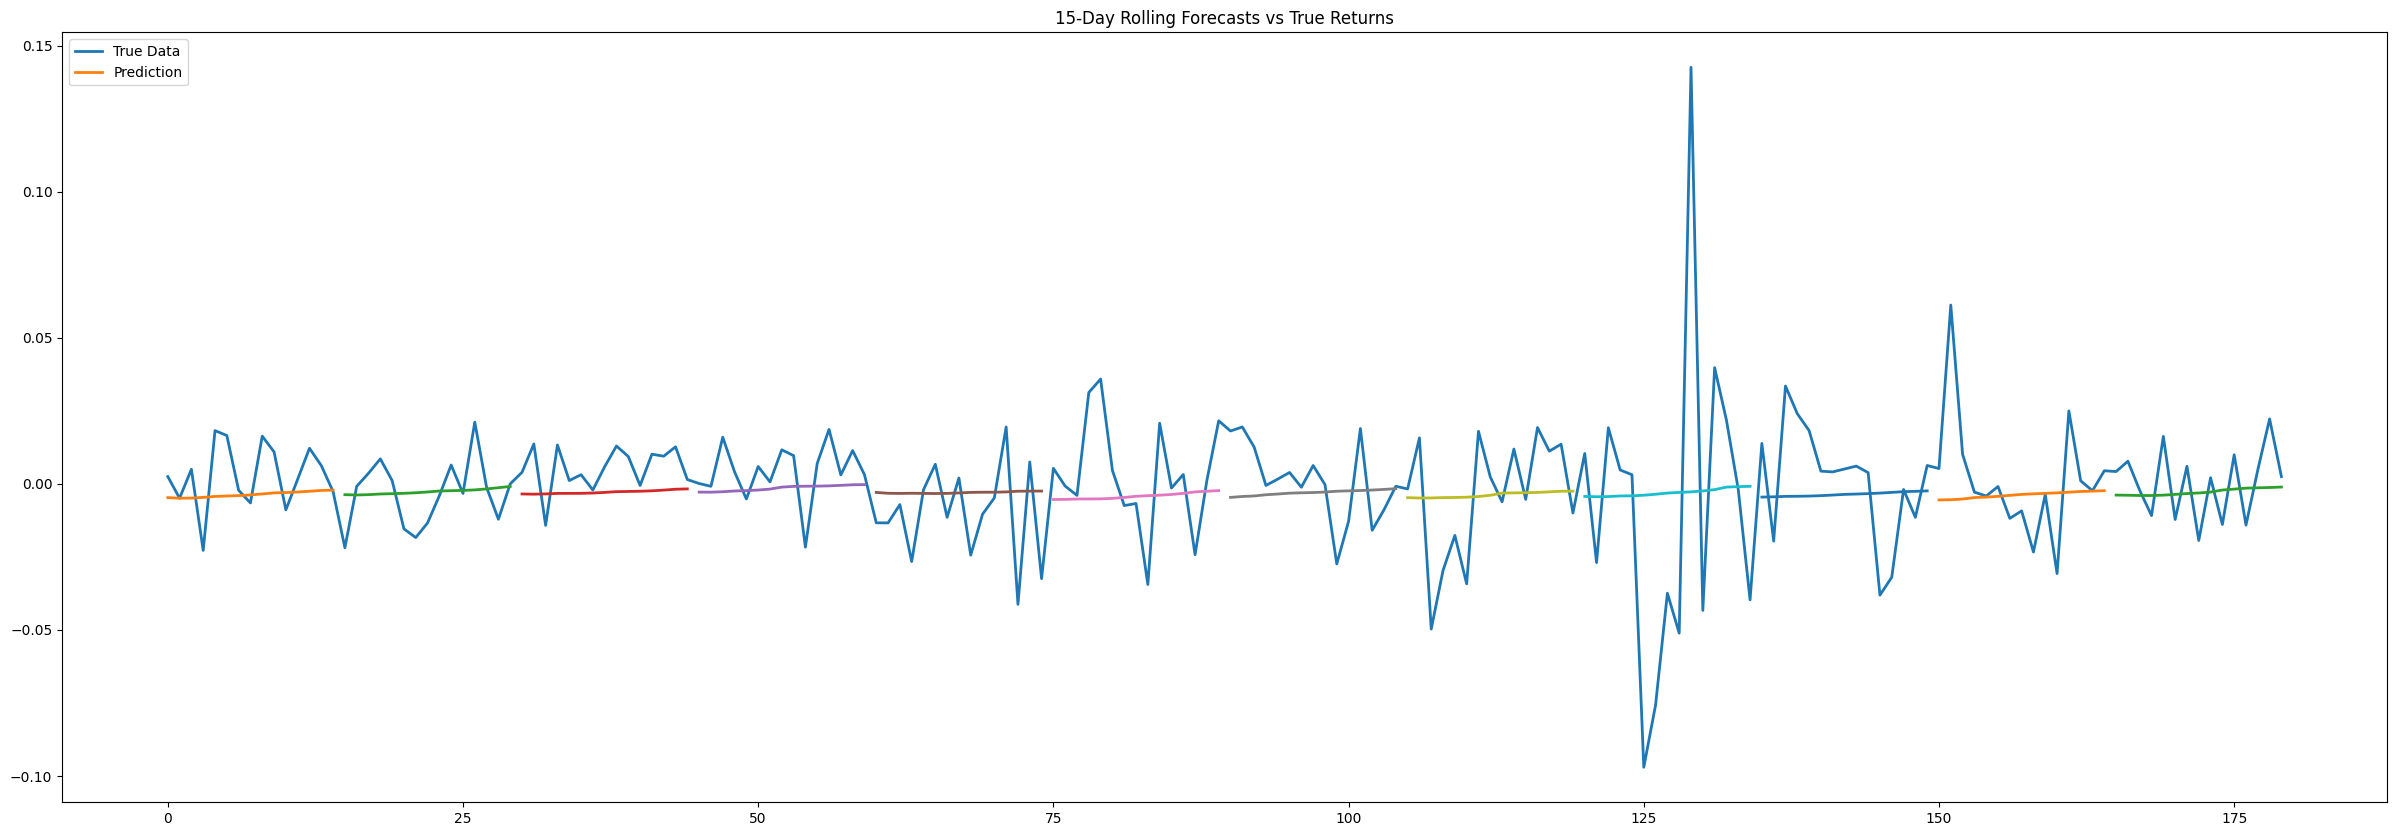

In [34]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing    import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ─── 1) DATA & FEATURES ────────────────────────────────────────────────────────

ticker = "AAPL"
df = yf.download(ticker, start="2018-01-01", end="2025-06-30")

# moving averages
for w in [5,10,20]:
    df[f"MA_{w}"] = df["Close"].rolling(w).mean()

# RSI
def compute_rsi(s, window=14):
    d  = s.diff()
    up =  d.clip(lower=0).rolling(window).mean()
    dn = -d.clip(upper=0).rolling(window).mean()
    rs = up/dn
    return 100 - 100/(1+rs)
df["RSI_14"] = compute_rsi(df["Close"],14)

# MACD
ema12 = df["Close"].ewm(span=12, adjust=False).mean()
ema26 = df["Close"].ewm(span=26, adjust=False).mean()
df["MACD"]     = ema12 - ema26
df["MACD_SIG"] = df["MACD"].ewm(span=9, adjust=False).mean()

# Bollinger Bands
bbm = df["Close"].rolling(20).mean()
bbs = df["Close"].rolling(20).std()
df["BB_upper"] = bbm + 2*bbs
df["BB_lower"] = bbm - 2*bbs

# OBV (vectorized)
delta = df["Close"].diff()
sign  = np.sign(delta).fillna(0)
df["OBV"]     = (sign * df["Volume"]).cumsum()

# calendar
df["dow_sin"] = np.sin(2*np.pi*df.index.dayofweek/7)
df["dow_cos"] = np.cos(2*np.pi*df.index.dayofweek/7)
df["mon_sin"] = np.sin(2*np.pi*df.index.month/12)
df["mon_cos"] = np.cos(2*np.pi*df.index.month/12)
df["is_month_end"] = df.index.is_month_end.astype(int)

# target: next‐day log return
df["log_ret"] = np.log(df["Close"]/df["Close"].shift(1))
df.dropna(inplace=True)

FEATURES = [
    "Open","High","Low","Close","Volume",
    "MA_5","MA_10","MA_20",
    "RSI_14","MACD","MACD_SIG",
    "BB_upper","BB_lower","OBV",
    "dow_sin","dow_cos","mon_sin","mon_cos","is_month_end"
]
X = df[FEATURES].values
y = df["log_ret"].values   # continuous target

# ─── 2) SCALE & SLIDING WINDOWS ────────────────────────────────────────────────

scaler = StandardScaler()
X = scaler.fit_transform(X)

SEQ_LEN = 30
Xs, ys = [], []
for i in range(len(X)-SEQ_LEN):
    Xs.append(X[i:i+SEQ_LEN])
    ys.append(y[i+SEQ_LEN])
X = np.stack(Xs)   # (N, seq, feat)
y = np.array(ys)

# ─── 3) SPLIT & DATALOADERS ───────────────────────────────────────────────────

X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_te, y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.5, shuffle=False)

class TSDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_loader = DataLoader(TSDataset(X_tr, y_tr), batch_size=64, shuffle=True)
val_loader   = DataLoader(TSDataset(X_val, y_val), batch_size=64)
test_loader  = DataLoader(TSDataset(X_te, y_te), batch_size=64)

# ─── 4) MODEL (regression) ────────────────────────────────────────────────────

class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim, 1)
    def forward(self, H):
        # H: (batch, seq, hid)
        w = torch.softmax(self.attn(H).squeeze(-1), dim=1)      # (batch, seq)
        c = torch.bmm(w.unsqueeze(1), H).squeeze(1)             # (batch, hid)
        return c

class BiAttnLSTMReg(nn.Module):
    def __init__(self, in_dim, hid_dim=128, n_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hid_dim,
                            num_layers=n_layers,
                            bidirectional=True,
                            batch_first=True,
                            dropout=dropout)
        self.attn = Attention(hid_dim*2)
        self.fc   = nn.Linear(hid_dim*2, 1)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        H, _ = self.lstm(x)
        c    = self.attn(H)
        return self.fc(self.drop(c))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = BiAttnLSTMReg(in_dim=X.shape[2]).to(device)

# ─── 5) TRAINING SETUP ────────────────────────────────────────────────────────

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)

def run_epoch(loader, train=False):
    if train: model.train()
    else:     model.eval()
    tot_loss = 0
    with torch.set_grad_enabled(train):
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            if train: optimizer.zero_grad()
            pred = model(Xb)
            loss = criterion(pred, yb)
            if train:
                loss.backward()
                optimizer.step()
            tot_loss += loss.item()*Xb.size(0)
    return tot_loss/len(loader.dataset)

best_val = float('inf')
patience, wait = 5, 0

for epoch in range(1,51):
    tr_loss = run_epoch(train_loader, train=True)
    va_loss = run_epoch(val_loader,   train=False)
    scheduler.step(va_loss)
    print(f"Epoch {epoch:02d}  Train MSE={tr_loss:.6f}  Val MSE={va_loss:.6f}")
    if va_loss < best_val:
        best_val = va_loss
        wait = 0
        torch.save(model.state_dict(), "best_model_reg.pth")
    else:
        wait += 1
        if wait >= patience:
            print(f"⏹ Early stopping at epoch {epoch}")
            break

model.load_state_dict(torch.load("best_model_reg.pth"))

# ─── 6) FORECAST & PLOT ────────────────────────────────────────────────────────

HORIZON = 15

def forecast_chunks(model, X_windows, horizon):
    model.eval()
    chunks = []
    with torch.no_grad():
        for start in range(0, len(X_windows)-horizon, horizon):
            seq = X_windows[start].copy()      # (seq,feat)
            preds = []
            for _ in range(horizon):
                x_in = torch.tensor(seq[None], dtype=torch.float32).to(device)
                out  = model(x_in).item()
                preds.append(out)
                # shift window in only the RETURN feature:
                next_row = np.zeros(seq.shape[1])
                # find index of log_ret in your FEATURES list:
                RET_IDX = FEATURES.index("Close")  # replace with actual index if needed
                next_row[RET_IDX] = 0               # no direct OHLCV shift
                seq = np.vstack([seq[1:], next_row])
            chunks.append(preds)
    return np.array(chunks)

def plot_results_multiple(pred_chunks, true_series, horizon):
    plt.figure(figsize=(30,10))
    plt.plot(true_series, label="True Data", lw=2)
    for i, chunk in enumerate(pred_chunks):
        start, end = i*horizon, i*horizon+horizon
        plt.plot(
            np.arange(start,end),
            chunk,
            lw=2,
            label="Prediction" if i==0 else None
        )
    plt.legend(loc="upper left")
    plt.title(f"{horizon}-Day Rolling Forecasts vs True Returns")
    plt.show()

# assemble predictions + true series
pred_chunks = forecast_chunks(model, X_te, HORIZON)
true_returns = y_te[:len(pred_chunks)*HORIZON]

plot_results_multiple(pred_chunks, true_returns, HORIZON)

In [36]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing    import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics         import accuracy_score, classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# ─── HYPERPARAMS ──────────────────────────────────────────────────────────────
TICKER      = "AAPL"
PERIOD      = "60d"      # intraday limit
INTERVAL    = "1h"
SEQ_LEN     = 30
BATCH       = 64
LR          = 1e-3
WEIGHT_DECAY= 1e-5
N_EPOCHS    = 50
PATIENCE    = 5

# ─── 1) DOWNLOAD RAW & SAVE ────────────────────────────────────────────────────
df = yf.download(TICKER, period=PERIOD, interval=INTERVAL)
df.to_csv("aapl_hourly_raw.csv")
print("→ Saved raw hourly data to aapl_hourly_raw.csv")

# ─── 2) FEATURE ENGINEERING ────────────────────────────────────────────────────
# moving averages
for w in (5,10,20):
    df[f"MA_{w}"] = df["Close"].rolling(w).mean()

# RSI
def compute_rsi(s, window=14):
    d  = s.diff()
    up =  d.clip(lower=0).rolling(window).mean()
    dn = -d.clip(upper=0).rolling(window).mean()
    rs = up/dn
    return 100 - 100/(1+rs)
df["RSI_14"] = compute_rsi(df["Close"],14)

# MACD & signal
ema12 = df["Close"].ewm(span=12, adjust=False).mean()
ema26 = df["Close"].ewm(span=26, adjust=False).mean()
df["MACD"]     = ema12 - ema26
df["MACD_SIG"] = df["MACD"].ewm(span=9, adjust=False).mean()

# Bollinger Bands
bbm = df["Close"].rolling(20).mean()
bbs = df["Close"].rolling(20).std()
df["BB_upper"] = bbm + 2*bbs
df["BB_lower"] = bbm - 2*bbs

# On-Balance Volume
delta = df["Close"].diff()
sign  = np.sign(delta).fillna(0)
df["OBV"]     = (sign * df["Volume"]).cumsum()

# calendar + intraday
df["dow_sin"]     = np.sin(2*np.pi*df.index.dayofweek/7)
df["dow_cos"]     = np.cos(2*np.pi*df.index.dayofweek/7)
df["mon_sin"]     = np.sin(2*np.pi*df.index.month/12)
df["mon_cos"]     = np.cos(2*np.pi*df.index.month/12)
df["hour_sin"]    = np.sin(2*np.pi*df.index.hour/24)
df["hour_cos"]    = np.cos(2*np.pi*df.index.hour/24)
df["is_month_end"]= df.index.is_month_end.astype(int)

# label: up/down next‐hour
df["log_ret"] = np.log(df["Close"]/df["Close"].shift(1))
df["label"]   = (df["log_ret"].shift(-1) > 0).astype(int)
df.dropna(inplace=True)

# keep timestamps
ts = df.index

FEATURES = [
    "Open","High","Low","Close","Volume",
    "MA_5","MA_10","MA_20",
    "RSI_14","MACD","MACD_SIG",
    "BB_upper","BB_lower","OBV",
    "dow_sin","dow_cos","mon_sin","mon_cos",
    "hour_sin","hour_cos","is_month_end"
]

X = df[FEATURES].values
y = df["label"].values

# ─── 3) SCALE & SLIDING WINDOWS ────────────────────────────────────────────────
scaler = StandardScaler()
X = scaler.fit_transform(X)

Xw, yw, tsw = [], [], []
for i in range(len(X) - SEQ_LEN):
    Xw.append(X[i:i+SEQ_LEN])
    yw.append(y[i+SEQ_LEN])
    tsw.append(ts[i+SEQ_LEN])
Xw  = np.stack(Xw)  # (N, SEQ_LEN, D)
yw  = np.array(yw)  # (N,)
tsw = np.array(tsw)

# ─── 4) TRAIN/VAL/TEST SPLIT & DATALOADERS ────────────────────────────────────
X_tr, X_tmp, y_tr, y_tmp, ts_tr, ts_tmp = train_test_split(
    Xw, yw, tsw, test_size=0.2, shuffle=False
)
X_val, X_te, y_val, y_te, ts_val, ts_te = train_test_split(
    X_tmp, y_tmp, ts_tmp, test_size=0.5, shuffle=False
)

class TSDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

# oversample minority class in training
counts = np.bincount(y_tr)
cw = 1.0 / counts
weights = cw[y_tr]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(TSDataset(X_tr,y_tr), batch_size=BATCH, sampler=sampler)
val_loader   = DataLoader(TSDataset(X_val,y_val), batch_size=BATCH)
test_loader  = DataLoader(TSDataset(X_te,y_te),   batch_size=BATCH)

# ─── 5) MODEL: CNN → Bi‐LSTM → Attention → Classifier ─────────────────────────
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim, 1)
    def forward(self, H):
        w = torch.softmax(self.attn(H).squeeze(-1), dim=1)   # (B, seq)
        c = torch.bmm(w.unsqueeze(1), H).squeeze(1)          # (B, hid)
        return c

class CnnLstmCls(nn.Module):
    def __init__(self, in_dim, hid_dim=128, n_layers=2, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_dim, 64, kernel_size=3, padding=1)
        self.relu  = nn.ReLU()
        self.lstm  = nn.LSTM(64, hid_dim, num_layers=n_layers,
                             batch_first=True, bidirectional=True,
                             dropout=dropout)
        self.attn  = Attention(hid_dim*2)
        self.drop  = nn.Dropout(dropout)
        self.fc    = nn.Linear(hid_dim*2, 2)

    def forward(self, x):
        # x: (B, seq, feat) → (B, feat, seq)
        c = self.relu(self.conv1(x.transpose(1,2)))
        # to (B, seq, 64)
        H,_ = self.lstm(c.transpose(1,2))
        c   = self.attn(H)
        return self.fc(self.drop(c))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CnnLstmCls(in_dim=Xw.shape[2]).to(device)

# ─── 6) TRAINING ──────────────────────────────────────────────────────────────
criterion = nn.CrossEntropyLoss(weight=torch.tensor(counts.sum()/counts, dtype=torch.float32).to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=3
)

def run_epoch(loader, train=False):
    model.train() if train else model.eval()
    tot_loss = tot_acc = 0
    with torch.set_grad_enabled(train):
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            if train: optimizer.zero_grad()
            logits = model(Xb)                       # (B, 2)
            loss   = criterion(logits, yb)
            if train:
                loss.backward(); optimizer.step()
            preds = logits.argmax(dim=1)
            tot_acc  += (preds==yb).sum().item()
            tot_loss += loss.item()*Xb.size(0)
    n = len(loader.dataset)
    return tot_loss/n, tot_acc/n

best_val_acc, wait = 0.0, 0
for epoch in range(1, N_EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader,   train=False)
    scheduler.step(va_acc)
    print(f"Epoch {epoch:02d}  Train: {tr_loss:.4f}/{tr_acc:.3f}  Val : {va_loss:.4f}/{va_acc:.3f}")
    if va_acc > best_val_acc:
        best_val_acc, wait = va_acc, 0
        torch.save(model.state_dict(), "best_cnnlstm.pth")
    else:
        wait += 1
        if wait >= PATIENCE:
            print(f"⏹ Early stopping at epoch {epoch}")
            break

# reload best
model.load_state_dict(torch.load("best_cnnlstm.pth"))

# ─── 7) EVALUATE & REPORT ─────────────────────────────────────────────────────
test_loss, test_acc = run_epoch(test_loader, train=False)
print(f"\nTest Accuracy: {test_acc:.3f}")

all_preds, all_trues = [], []
model.eval()
with torch.no_grad():
    for Xb, yb in test_loader:
        logits = model(Xb.to(device))
        ps = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(ps)
        all_trues.append(yb.numpy())
all_preds = np.concatenate(all_preds)
all_trues = np.concatenate(all_trues)

print(classification_report(all_trues, all_preds,
      target_names=["Down","Up"], digits=3))

# ─── 8) SAVE PREDICTIONS ──────────────────────────────────────────────────────
pd.DataFrame({
    "timestamp": ts_te,
    "true":      all_trues,
    "pred":      all_preds
}).to_csv("aapl_hourly_cnnlstm_preds.csv", index=False)
print("→ Saved CNN-LSTM preds to aapl_hourly_cnnlstm_preds.csv")


/tmp/ipython-input-36-2132854963.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, period=PERIOD, interval=INTERVAL)
[*********************100%***********************]  1 of 1 completed


→ Saved raw hourly data to aapl_hourly_raw.csv
Epoch 01  Train: 0.7017/0.433  Val : 0.6936/0.486
Epoch 02  Train: 0.6933/0.481  Val : 0.6956/0.486
Epoch 03  Train: 0.6947/0.502  Val : 0.6960/0.486
Epoch 04  Train: 0.6938/0.512  Val : 0.6943/0.514
Epoch 05  Train: 0.6932/0.532  Val : 0.6972/0.514
Epoch 06  Train: 0.6846/0.546  Val : 0.6935/0.514
Epoch 07  Train: 0.6825/0.587  Val : 0.6932/0.514
Epoch 08  Train: 0.7005/0.495  Val : 0.6949/0.514
Epoch 09  Train: 0.6807/0.553  Val : 0.6925/0.514
⏹ Early stopping at epoch 9

Test Accuracy: 0.459
              precision    recall  f1-score   support

        Down      0.459     1.000     0.630        17
          Up      0.000     0.000     0.000        20

    accuracy                          0.459        37
   macro avg      0.230     0.500     0.315        37
weighted avg      0.211     0.459     0.289        37

→ Saved CNN-LSTM preds to aapl_hourly_cnnlstm_preds.csv


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
